# Consensus Evaluation
This notebook standardizes and prepares datasets for the six behavior metrics in a unified structure, ensuring consistency and compatible formats for downstream comparative and consensus analyses. After dataset harmonization, the notebook conducts the consensus analysis through metric flags and an UpSet plot using the standardized metrics. It then computes and visualizes consensus statistics summarizing the alignment patterns and deviations between AV and HDV behaviors across the two sites. At the end, a sensitivity analysis is conducted to check the sensitivoty of our analysis to our threshold selection.

## Regenerating Datasets - Foggy Bottom
We need every AV to be traced back to an event, which is a left turn maneuver. In the TGSIM dataset, every AV with a unique `id` turns left at all four intersections. Adding a `lane_kf`-based intersection identified helps separate the events for a better consensus analysis. 

In [25]:
# TTC
import pandas as pd
import numpy as np
import json

# Load source data
tgsim = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")
with open("AV_Interaction_Log.json", "r") as f:
    interaction_log = pd.DataFrame(json.load(f))
with open("AV_Detection_Details.json", "r") as f:
    detection_details = pd.DataFrame(json.load(f))

# Merge AV motion info
df_ttc = detection_details.merge(
    tgsim, left_on=["time", "av_id"], right_on=["time", "id"], suffixes=("_det", "_av")
)
df_ttc = df_ttc.merge(
    tgsim, left_on=["time", "agent_id"], right_on=["time", "id"], suffixes=("_av", "_agent")
)

# Assign intersection (AV lane_kf)
df_ttc["lane_kf"] = df_ttc["lane_kf_av"]
df_ttc["intersection"] = np.where(df_ttc["lane_kf"].isin([1, 2, 3, 4]), df_ttc["lane_kf"], np.nan)

# Compute relative motion & TTC
df_ttc["dx"] = df_ttc["xloc_kf_agent"] - df_ttc["xloc_kf_av"]
df_ttc["dy"] = df_ttc["yloc_kf_agent"] - df_ttc["yloc_kf_av"]
df_ttc["distance"] = np.sqrt(df_ttc["dx"]**2 + df_ttc["dy"]**2)
df_ttc["unit_x"] = df_ttc["dx"] / df_ttc["distance"]
df_ttc["unit_y"] = df_ttc["dy"] / df_ttc["distance"]
df_ttc["V_rel_x"] = df_ttc["speed_kf_x_agent"] - df_ttc["speed_kf_x_av"]
df_ttc["V_rel_y"] = df_ttc["speed_kf_y_agent"] - df_ttc["speed_kf_y_av"]
df_ttc["V_rel"] = df_ttc["V_rel_x"] * df_ttc["unit_x"] + df_ttc["V_rel_y"] * df_ttc["unit_y"]
df_ttc["TTC"] = df_ttc["distance"] / df_ttc["V_rel"]

# Handle edge cases
df_ttc.loc[df_ttc["V_rel"] <= 0, "TTC"] = np.inf
df_ttc.loc[df_ttc["distance"] == 0, "TTC"] = 0

# Aggregate by AV-event (take min TTC per AV-intersection)
ttc_consensus = (
    df_ttc.groupby(["av_id", "intersection"], as_index=False)
          .agg({"TTC": "min"})
)

# Save consensus-ready TTC dataset
ttc_consensus.to_csv("AV_TTC_Consensus_FB.csv", index=False)
print(f"Saved {len(ttc_consensus)} rows to AV_TTC_Consensus_FB.csv")

Saved 70 rows to AV_TTC_Consensus_FB.csv


In [26]:
# PET
import pandas as pd
import numpy as np
import json

# Load data
tgsim = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")
with open("AV_Interaction_Log.json", "r") as f:
    interaction_log = pd.DataFrame(json.load(f))

# VRUs & AVs
vru_types = [0, 1, 2]
tgsim_vru = tgsim[tgsim["type_most_common"].isin(vru_types)]
tgsim_av = tgsim[tgsim["type_most_common"] == 4]

interaction_log = interaction_log.explode("agent_ids").rename(columns={"agent_ids": "agent_id"})
interaction_pairs = interaction_log[["av_id", "agent_id"]].drop_duplicates()

# Compute PET
pet_list = []
for _, row in interaction_pairs.iterrows():
    av_id, agent_id = row["av_id"], row["agent_id"]

    av_traj = tgsim_av[tgsim_av["id"] == av_id][["time", "xloc_kf", "yloc_kf", "lane_kf"]]
    agent_traj = tgsim_vru[tgsim_vru["id"] == agent_id][["time", "xloc_kf", "yloc_kf"]]

    if av_traj.empty or agent_traj.empty:
        continue

    av_traj["key"] = agent_traj["key"] = 1
    merged = pd.merge(av_traj, agent_traj, on="key", suffixes=("_av", "_agent")).drop(columns="key")
    merged["distance"] = np.sqrt((merged["xloc_kf_av"] - merged["xloc_kf_agent"])**2 +
                                 (merged["yloc_kf_av"] - merged["yloc_kf_agent"])**2)
    if merged["distance"].min() > 5:
        continue

    encroach = merged.loc[merged["distance"].idxmin()]
    intersection = encroach["lane_kf"] if encroach["lane_kf"] in [1, 2, 3, 4] else np.nan
    pet = abs(encroach["time_av"] - encroach["time_agent"])

    pet_list.append({"av_id": av_id, "intersection": intersection, "PET": pet})

# Aggregate per AV-intersection (worst PET)
df_pet = pd.DataFrame(pet_list)
pet_consensus = df_pet.groupby(["av_id", "intersection"], as_index=False)["PET"].min()
pet_consensus.to_csv("AV_PET_Consensus_FB.csv", index=False)
print(f"Saved PET consensus with {len(pet_consensus)} rows")

Saved PET consensus with 40 rows


In [30]:
# String stability
import pandas as pd

# Load the stability results
gain = pd.read_csv("AV_String_Stability_Results_FB.csv")

# Map source_lane → intersection (based on your mapping)
lane_to_intersection = {
    29: 1,
    25: 2,
    15: 3,
    34: 4
}
gain["intersection"] = gain["source_lane"].map(lane_to_intersection)

# We’ll treat each *AV-led* platoon as the event (lead_id is the AV)
gain = gain.rename(columns={"lead_id": "av_id"})

# Keep only relevant columns for consensus alignment
gain_consensus = gain[["av_id", "intersection", "gain"]]

# Save updated version
gain_consensus.to_csv("AV_String_Stability_Results_FB_Aligned.csv", index=False)
print(f"Saved aligned string stability dataset with {len(gain_consensus)} rows.")

Saved aligned string stability dataset with 19 rows.


In [61]:
# Headways
import pandas as pd

# Load the raw AV headway dataset
headway_raw = pd.read_csv("AV_Intersection_Headways_FB.csv")

# Keep only exit transitions (from the generated combined dataset)
lane_pairs_exit = [
    (2, 37),  # top-left
    (1, 40),  # top-right
    (3, 48),  # bottom-left
    (4, 42)   # bottom-right
]
exit_sources = [pair[0] for pair in lane_pairs_exit]
headway_exit = headway_raw[headway_raw["source_lane"].isin(exit_sources)].copy()

# Map source_lane → intersection ID (1–4)
lane_to_intersection = {
    29: 1,  # entry pair top-left (not used here)
    25: 2,  # entry pair top-right (not used here)
    15: 3,  # entry pair bottom-left (not used here)
    34: 4,  # entry pair bottom-right (not used here)
    # Now map exit source lanes directly
    2: 1,   # top-left exit
    1: 2,   # top-right exit
    3: 3,   # bottom-left exit
    4: 4    # bottom-right exit
}
headway_exit["intersection"] = headway_exit["source_lane"].map(lane_to_intersection)

# Only keep AVs
vehicle_types = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")[["id", "type_most_common"]].drop_duplicates()
headway_exit = headway_exit.merge(vehicle_types, left_on="agent_id", right_on="id", how="left")
headway_exit = headway_exit[headway_exit["type_most_common"] == 4]  # Keep only AVs

# Aggregate to one row per AV–intersection (average exit headway)
headway_consensus = (
    headway_exit.groupby(["agent_id", "intersection"], as_index=False)["time_headway"]
    .min()
    .rename(columns={"agent_id": "av_id"})
)

# Save for later consensus merging
headway_consensus.to_csv("AV_Exit_Headways_FB.csv", index=False)
print(f"Saved exit headway dataset with {len(headway_consensus)} AV–intersection rows.")


Saved exit headway dataset with 56 AV–intersection rows.


In [38]:
# Jerk
import pandas as pd
import numpy as np

# Load transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")

# Keep only AVs (type_most_common == 4) — HDVs excluded here since we want AV metrics
tgsim_av = tgsim[tgsim["type_most_common"] == 4].copy()

# Map lanes to intersection IDs for all rows (to group events correctly)
lane_to_intersection = {
    29: 1,
    25: 2,
    15: 3,
    34: 4
}
tgsim_av["intersection"] = tgsim_av["lane_kf"].map(lane_to_intersection)

# Filter to only rows that belong to intersections we care about
tgsim_av = tgsim_av[tgsim_av["intersection"].notna()]

# Parameters
window_size = 10  # 1 second (10 frames)
jerk_events = []

# Compute Jerk per AV-intersection group
for (av_id, intersection), group in tgsim_av.groupby(["id", "intersection"]):
    group = group.sort_values("time")

    # Compute acceleration magnitude (combine x and y)
    acc_x = group["acceleration_kf_x"].values
    acc_y = group["acceleration_kf_y"].values

    # Skip groups too short for a 1-second jerk window
    if len(acc_x) < window_size + 1:
        continue

    # Smooth acceleration to reduce noise (5-frame rolling mean)
    acc_x_smooth = pd.Series(acc_x).rolling(window=5, center=True, min_periods=1).mean().values
    acc_y_smooth = pd.Series(acc_y).rolling(window=5, center=True, min_periods=1).mean().values

    # Jerk as time derivative of acceleration
    jerk_x = np.diff(acc_x_smooth) / 0.1
    jerk_y = np.diff(acc_y_smooth) / 0.1
    jerk_mag = np.sqrt(jerk_x**2 + jerk_y**2)

    # Find max RMS jerk window for this AV-intersection
    max_rms = -np.inf
    max_data = None

    for i in range(len(jerk_mag) - window_size + 1):
        jerk_window = jerk_mag[i:i + window_size]
        rms = np.sqrt(np.mean(jerk_window**2))
        if rms > max_rms:
            max_rms = rms
            max_data = {
                "av_id": av_id,
                "intersection": intersection,
                "rms_jerk": rms,
                "max_jerk": jerk_window.max()
            }

    if max_data:
        jerk_events.append(max_data)

# Combine into DataFrame
jerk_df = pd.DataFrame(jerk_events)
jerk_df.to_csv("AV_Jerk_PerEvent_FB.csv", index=False)
print(f"Saved Jerk per-event dataset with {len(jerk_df)} AV-intersection rows.")


Saved Jerk per-event dataset with 63 AV-intersection rows.


In [37]:
# Deceleration Intensity
import pandas as pd
import numpy as np

# Load data
tgsim = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")
avs = tgsim[(tgsim["type_most_common"] == 4) & (tgsim["acceleration_kf_x"].notna())]

avs["decel"] = np.sqrt(avs["acceleration_kf_x"]**2 + avs["acceleration_kf_y"]**2)
avs["intersection"] = np.where(avs["lane_kf"].isin([1,2,3,4]), avs["lane_kf"], np.nan)

# Worst deceleration per AV-intersection
decel_consensus = avs.groupby(["id", "intersection"], as_index=False)["decel"].max()
decel_consensus = decel_consensus.rename(columns={"id":"av_id", "decel":"Decel"})
decel_consensus.to_csv("AV_Decel_Consensus_FB.csv", index=False)
print(f"Saved Deceleration consensus with {len(decel_consensus)} rows")


Saved Deceleration consensus with 70 rows


C:\Users\msela\AppData\Local\Temp\ipykernel_22744\3137787352.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avs["decel"] = np.sqrt(avs["acceleration_kf_x"]**2 + avs["acceleration_kf_y"]**2)
C:\Users\msela\AppData\Local\Temp\ipykernel_22744\3137787352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avs["intersection"] = np.where(avs["lane_kf"].isin([1,2,3,4]), avs["lane_kf"], np.nan)


## Regenerating Datasets - I-395
Now we're regenerating datasets for the I-395 data. We're defining events based on 10-second windows here. 

In [14]:
# Creating 10 second time windows

import pandas as pd
import numpy as np

# Load transformed I-395 dataset and filter for AVs
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
avs = tgsim[tgsim["type_most_common"] == 4].copy()

# Build a master list of 10-second windows for each AV
master_windows = []
for av_id, group in avs.groupby("id"):
    start = group["time"].min()
    end = group["time"].max()
    windows = range(int(start // 10), int(end // 10) + 1)

    for w in windows:
        # Optional: get lane_kf mode for this time slice (for grouping later)
        lane_slice = group[group["time"].between(w * 10, (w + 1) * 10)]
        lane_kf = lane_slice["lane_kf"].mode()
        lane_kf = lane_kf.iloc[0] if not lane_kf.empty else np.nan

        master_windows.append({"av_id": av_id, "window": w, "lane_kf": lane_kf})

master_df = pd.DataFrame(master_windows)
master_df["intersection"] = float("nan")  # placeholder for consistency
master_df.to_csv("AV_Master_Windows_I395.csv", index=False)

print(f"Created master window list: {len(master_df)} AV-window rows across all AVs.")


Created master window list: 119 AV-window rows across all AVs.


In [15]:
# TTC
import pandas as pd

# Load precomputed TTC data and master window list
ttc_df = pd.read_csv("TTC_I395_AV.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
avs = tgsim[tgsim["type_most_common"] == 4][["id", "time", "lane_kf"]]

# Attach AV lane_kf for context
ttc_df = ttc_df.merge(avs, left_on=["av_id", "time"], right_on=["id", "time"], how="left")
ttc_df = ttc_df.rename(columns={"lane_kf": "lane_kf_av"}).drop(columns=["id"])
ttc_df["window"] = (ttc_df["time"] // 10).astype(int)

# Aggregate per AV-window
ttc_summary = (
    ttc_df.groupby(["av_id", "window", "lane_kf_av"], as_index=False)
    .agg(
        min_TTC=("TTC", "min"),
        pct_below_3s=("TTC", lambda x: (x < 3).mean() * 100),
        mean_distance=("distance", "mean"),
        n_frames=("time", "count")
    )
    .rename(columns={"lane_kf_av": "lane_kf"})
)

# Align with master window list
ttc_summary = master_df.merge(ttc_summary, on=["av_id", "window", "lane_kf"], how="left")
ttc_summary.to_csv("AV_TTC_Summary_I395.csv", index=False)
print(f"TTC summary aligned: {len(ttc_summary)} rows (one per AV-window).")


TTC summary aligned: 119 rows (one per AV-window).


In [16]:
# PET
import pandas as pd

# Load precomputed PET results and master window list
pet_df = pd.read_csv("PET_I395_AVs.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
avs = tgsim[tgsim["type_most_common"] == 4][["id", "time", "lane_kf"]]

# Attach AV lane_kf and compute window index
pet_df = pet_df.merge(avs, left_on=["av_id", "av_time"], right_on=["id", "time"], how="left")
pet_df = pet_df.rename(columns={"lane_kf": "lane_kf_av"}).drop(columns=["id", "time"])
pet_df["window"] = (pet_df["av_time"] // 10).astype(int)

# Aggregate per AV-window
pet_summary = (
    pet_df.groupby(["av_id", "window", "lane_kf_av"], as_index=False)
    .agg(
        min_PET=("PET", "min"),
        pct_below_2_25s=("PET", lambda x: (x < 2.25).mean() * 100),
        n_events=("PET", "count")
    )
    .rename(columns={"lane_kf_av": "lane_kf"})
)

# Align with master window list
pet_summary = master_df.merge(pet_summary, on=["av_id", "window", "lane_kf"], how="left")
pet_summary.to_csv("AV_PET_Summary_I395.csv", index=False)
print(f"PET summary aligned: {len(pet_summary)} rows (one per AV-window).")


PET summary aligned: 119 rows (one per AV-window).


In [17]:
# Jerk
import pandas as pd
import numpy as np

# Load transformed dataset and master window list
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")
avs = tgsim[(tgsim["type_most_common"] == 4) & (tgsim["lane_kf"].isin([-4, -3, -2]))].copy()

window_size = 10  # 1 second (10 frames)
jerk_records = []

# Compute peak RMS jerk per AV (as before)
for av_id, group in avs.groupby("id"):
    group = group.sort_values("time")
    acc_raw = group["acceleration_kf"].values

    if len(acc_raw) < window_size + 1:
        continue

    acc = pd.Series(acc_raw).rolling(window=5, center=True, min_periods=1).mean().values
    jerk = np.diff(acc) / 0.1

    max_rms_jerk = -np.inf
    best_time = None

    for i in range(len(jerk) - window_size + 1):
        jerk_window = jerk[i:i + window_size]
        rms = np.sqrt(np.mean(jerk_window**2))
        center_idx = i + 5 + 1
        if center_idx >= len(group):
            continue
        if rms > max_rms_jerk:
            max_rms_jerk = rms
            best_time = group.iloc[center_idx]["time"]

    if best_time is not None:
        jerk_records.append({"av_id": av_id, "time": best_time, "RMS_Jerk": max_rms_jerk})

jerk_df = pd.DataFrame(jerk_records)

# Assign lane_kf and window, aggregate per AV-window
avs_lane = avs[["id", "time", "lane_kf"]]
jerk_df = jerk_df.merge(avs_lane, left_on=["av_id", "time"], right_on=["id", "time"], how="left")
jerk_df = jerk_df.rename(columns={"lane_kf": "lane_kf_av"}).drop(columns=["id"])
jerk_df["window"] = (jerk_df["time"] // 10).astype(int)

jerk_summary = (
    jerk_df.groupby(["av_id", "window", "lane_kf_av"], as_index=False)
    .agg(max_RMS_Jerk=("RMS_Jerk", "max"))
    .rename(columns={"lane_kf_av": "lane_kf"})
)

# Align with master window list
jerk_summary = master_df.merge(jerk_summary, on=["av_id", "window", "lane_kf"], how="left")
jerk_summary.to_csv("AV_Jerk_Summary_I395.csv", index=False)
print(f"Jerk summary aligned: {len(jerk_summary)} rows (one per AV-window).")


Jerk summary aligned: 119 rows (one per AV-window).


In [18]:
# Deceleration Intensity
import pandas as pd
import numpy as np

# Load transformed dataset and master window list
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")

# Filter for AVs only in relevant lanes (-4, -3, -2) and decelerating (accel < 0)
avs = tgsim[(tgsim["type_most_common"] == 4) & 
            (tgsim["lane_kf"].isin([-4, -3, -2])) & 
            (tgsim["acceleration_kf"] < 0)].copy()

# Take absolute value for deceleration magnitude
avs["deceleration"] = avs["acceleration_kf"].abs()

# Tag each frame with its 10-second window
avs["window"] = (avs["time"] // 10).astype(int)

# Aggregate per AV-window: max decel, % frames above 2 m/s², frame counts
decel_summary = (
    avs.groupby(["id", "window", "lane_kf"], as_index=False)
    .agg(
        max_decel=("deceleration", "max"),
        pct_above_2=("deceleration", lambda x: (x > 2).mean() * 100),
        n_frames=("time", "count")
    )
    .rename(columns={"id": "av_id"})
)

# Align with master window list to ensure identical rows across metrics
decel_summary = master_df.merge(decel_summary, on=["av_id", "window", "lane_kf"], how="left")

# Save aligned summary
decel_summary.to_csv("AV_Decel_Summary_I395.csv", index=False)
print(f"Deceleration summary aligned: {len(decel_summary)} rows (one per AV-window).")


Deceleration summary aligned: 119 rows (one per AV-window).


In [19]:
# Headway
import pandas as pd

# Load the precomputed headway data and master window list
headway_df = pd.read_csv("I395_AV_Headway.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")

# Add 10-second window index to each record
headway_df["window"] = (headway_df["time"] // 10).astype(int)

# Aggregate per AV-window
# Metrics: min headway, avg headway, % frames below 4 seconds (performance threshold), frame count
headway_summary = (
    headway_df.groupby(["av_id", "window"], as_index=False)
    .agg(
        min_headway=("headway_time", "min"),
        avg_headway=("headway_time", "mean"),
        pct_below_4s=("headway_time", lambda x: (x < 4).mean() * 100),
        n_frames=("time", "count")
    )
)

# Merge with master window list to ensure identical AV-window rows
# (lane_kf and intersection come from the master file)
headway_summary = master_df.merge(headway_summary, on=["av_id", "window"], how="left")

# Save aligned headway summary
headway_summary.to_csv("AV_Headway_Summary_I395.csv", index=False)
print(f"Headway summary aligned: {len(headway_summary)} rows (one per AV-window).")


Headway summary aligned: 119 rows (one per AV-window).


In [53]:
# Gain
import pandas as pd
import numpy as np

# Load data
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
tgsim = tgsim[tgsim["lane_kf"] == -3].copy()

platoons_av = pd.read_csv("AV_Platoons_I395_Mid.csv")
master_df = pd.read_csv("AV_Master_Windows_I395.csv")  # all AV-window pairs

# Helper: extract acceleration norm over ±10s window
def get_acc_signal(agent_id, center_time):
    traj = tgsim[tgsim["id"] == agent_id].copy().sort_values("time")
    traj = traj[(traj["time"] >= center_time - 10) & (traj["time"] <= center_time + 10)]
    if traj.empty:
        return None
    traj["acc_norm"] = np.sqrt(traj["acceleration_kf"] ** 2)
    return traj["acc_norm"].values

records = []

# Loop through each AV-led platoon
for _, row in platoons_av.iterrows():
    lead_id = row["lead_id"]
    t0 = row["lead_entry_time"]
    members = eval(row["platoon_member_ids"])

    # Only the first follower matters
    if len(members) == 0:
        continue
    follower_id = members[0]

    # Fetch acceleration signals
    a_lead = get_acc_signal(lead_id, t0)
    a_follow = get_acc_signal(follower_id, t0)

    if a_lead is None or a_follow is None or len(a_lead) < 2 or len(a_follow) < 2:
        continue

    # Compute gain
    norm_lead = np.linalg.norm(a_lead)
    norm_follow = np.linalg.norm(a_follow)
    if norm_lead == 0:
        continue

    gain = norm_follow / norm_lead
    window = int(t0 // 10)  # cast to integer window index

    records.append({
        "av_id": lead_id,
        "window": window,
        "lane_kf": -3,
        "gain": gain
    })

gain_df = pd.DataFrame(records)

# Merge with master window list (to include all AV-window pairs, even NaNs)
gain_consensus = master_df.merge(gain_df, on=["av_id", "window", "lane_kf"], how="left")

# Save for consensus analysis
gain_consensus.to_csv("AV_Gain_Consensus_I395.csv", index=False)
print(f"Saved gain consensus with {len(gain_consensus)} rows (aligned with master windows).")


Saved gain consensus with 119 rows (aligned with master windows).


## Consensus Evaluation
### Consensus Behavior Flags
We're generating a dataset of consensus behavior flags for AVs at each intersection turn by evaluating their performance across key safety, interaction quality, and traffic efficiency metrics. For every AV-intersection pair, we raise a flag if the AV's behavior violates any of the following conditions: TTC ≤ 3.0 seconds, PET ≤ 2.25 seconds, deceleration ≥ 2.0 m/s<sup>2</sup>, jerk ≥ 2.5 m/s<sup>2</sup>, exit headway ≥ 4.0 seconds, or gain in string stability > 1.0. These thresholds reflect a combination of safety standards and observed HDV norms. The final output identifies AV events with at least one behavioral concern.

In [5]:
# Now creating a dataset for behavior flags

import pandas as pd
from functools import reduce
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# Defining the thresholds for violation flags
TTC_THRESH = 3.0
PET_THRESH = 2.25
DECEL_THRESH = 2.0
JERK_THRESH = 2.5
HEADWAY_THRESH = 4.0
GAIN_THRESH = 1.0

# === Loading Foggy Bottom datasets ===
ttc_fb = pd.read_csv("AV_TTC_Consensus_FB.csv")
pet_fb = pd.read_csv("AV_PET_Consensus_FB.csv")
decel_fb = pd.read_csv("AV_Decel_Consensus_FB.csv")
jerk_fb = pd.read_csv("AV_Jerk_PerEvent_FB.csv")
headway_fb = pd.read_csv("AV_Exit_Headways_FB.csv")  # already min headway per AV-intersection
gain_fb = pd.read_csv("AV_String_Stability_Results_FB_Aligned.csv")

# Renaming for clarity (based on how they were created)
jerk_fb["Jerk"] = jerk_fb["max_jerk"]
headway_fb["Headway"] = headway_fb["time_headway"]

# Flags for Foggy Bottom
ttc_fb["TTC_flag"] = ttc_fb["TTC"] <= TTC_THRESH
pet_fb["PET_flag"] = pet_fb["PET"] <= PET_THRESH
decel_fb["Decel_flag"] = decel_fb["Decel"] > DECEL_THRESH
jerk_fb["Jerk_flag"] = jerk_fb["Jerk"] > JERK_THRESH
gain_fb["Gain_flag"] = gain_fb["gain"] > GAIN_THRESH

# Marking eligibility (only events where the AV is following)
headway_fb["eligible"] = headway_fb["Headway"] <= 8
# Only compute Headway_flag for eligible events
headway_fb["Headway_flag"] = headway_fb.apply(
    lambda row: row["Headway"] < 4 if row["eligible"] else pd.NA, axis=1
)

# Creating event_id for FB
for df in [ttc_fb, pet_fb, decel_fb, jerk_fb, headway_fb, gain_fb]:
    df["event_id"] = df["av_id"].astype(str) + "_" + df["intersection"].astype(str)

# === Loading I-395 datasets ===
ttc_i = pd.read_csv("AV_TTC_Summary_I395.csv")
pet_i = pd.read_csv("AV_PET_Summary_I395.csv")
decel_i = pd.read_csv("AV_Decel_Summary_I395.csv")
jerk_i = pd.read_csv("AV_Jerk_Summary_I395.csv")
headway_i = pd.read_csv("AV_Headway_Summary_I395.csv")
gain_i = pd.read_csv("AV_Gain_Consensus_I395.csv")

# Using min_headway (instead of avg_headway) for I-395
headway_i["Headway"] = headway_i["min_headway"]

# Flags for I-395
ttc_i["TTC_flag"] = ttc_i["min_TTC"] <= TTC_THRESH
pet_i["PET_flag"] = pet_i["min_PET"] <= PET_THRESH
decel_i["Decel_flag"] = decel_i["max_decel"] > DECEL_THRESH
jerk_i["Jerk_flag"] = jerk_i["max_RMS_Jerk"] > JERK_THRESH
gain_i["Gain_flag"] = gain_i["gain"] > GAIN_THRESH

headway_i["eligible"] = headway_i["Headway"] <= 8
headway_i["Headway_flag"] = headway_i.apply(
    lambda row: row["Headway"] < 4 if row["eligible"] else pd.NA, axis=1
)


# Creating event_id for I-395 (AV + window)
for df in [ttc_i, pet_i, decel_i, jerk_i, headway_i, gain_i]:
    df["event_id"] = df["av_id"].astype(str) + "_" + df["window"].astype(str)

# === Helper to select and harmonize columns ===
def select_cols(df, value_col, flag_col, rename_value_as):
    return df.rename(columns={value_col: rename_value_as})[["event_id", "av_id", rename_value_as, flag_col]]

# Building a dataset list for merging
datasets = [
    # Foggy Bottom (values kept as-is with adjustments)
    select_cols(ttc_fb, "TTC", "TTC_flag", "TTC"),
    select_cols(pet_fb, "PET", "PET_flag", "PET"),
    select_cols(decel_fb, "Decel", "Decel_flag", "Decel"),
    select_cols(jerk_fb, "Jerk", "Jerk_flag", "Jerk"),
    select_cols(headway_fb, "Headway", "Headway_flag", "Headway"),
    select_cols(gain_fb, "gain", "Gain_flag", "Gain"),

    # I-395 (renamed for compatibility; using min_headway)
    select_cols(ttc_i, "min_TTC", "TTC_flag", "TTC"),
    select_cols(pet_i, "min_PET", "PET_flag", "PET"),
    select_cols(decel_i, "max_decel", "Decel_flag", "Decel"),
    select_cols(jerk_i, "max_RMS_Jerk", "Jerk_flag", "Jerk"),
    select_cols(headway_i, "Headway", "Headway_flag", "Headway"),
    select_cols(gain_i, "gain", "Gain_flag", "Gain"),
]

# Merging all into a single DataFrame
merged = reduce(lambda left, right: pd.merge(left, right, on=["event_id", "av_id"], how="outer"), datasets)

# Collecting only flags for visualization
flag_cols = [col for col in merged.columns if col.endswith("_flag")]
flags = merged[["event_id"] + flag_cols].fillna(False)

# Exporting to a csv
merged.to_csv("Merged_AV_Consensus_FB_I395.csv", index=False)

### Statistics
First, we want to look at what percent of time each objective was met. 

In [14]:
# Summary statistics (percentage meeting each condition)
import pandas as pd

# Loading the merged dataset
merged = pd.read_csv("Merged_AV_Consensus_FB_I395.csv")

# Correcting summary statistics
metrics = ["TTC", "PET", "Decel", "Jerk", "Headway", "Gain"]
percent_met = {}

for metric in metrics:
    # Extracting values and flags for FB (_x) and I-395 (_y)
    val_x = merged.get(f"{metric}_x")
    val_y = merged.get(f"{metric}_y")
    flag_x = merged.get(f"{metric}_flag_x")
    flag_y = merged.get(f"{metric}_flag_y")
    
    # Identifying events with valid metric values (either site)
    valid = val_x.notna() | val_y.notna()
    
    if valid.sum() > 0:
        # Combine flags: flagged if flagged in either dataset (but only where valid)
        combined_flag = ((flag_x & val_x.notna()).fillna(False) |
                         (flag_y & val_y.notna()).fillna(False))
        
        # Percentage of valid events meeting the objective (flag == False)
        percent_met[metric] = (combined_flag.loc[valid] == False).mean() * 100

# Converting to a sorted Series for display
percent_series = pd.Series(percent_met).sort_values(ascending=False)

print("\nPercentage of events meeting each objective (corrected):\n")
print(percent_series)


Percentage of events meeting each objective (corrected):

PET        81.012658
TTC        78.835979
Decel      61.290323
Headway    41.290323
Gain       38.709677
Jerk       26.190476
dtype: float64


### Visualizations
Now we want to generate an UpSet plot that helps understand how objectives are met related to one another and what patterns exist for violation co-occurrences. 

C:\Users\msela\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\msela\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

<Figure size 1200x600 with 0 Axes>

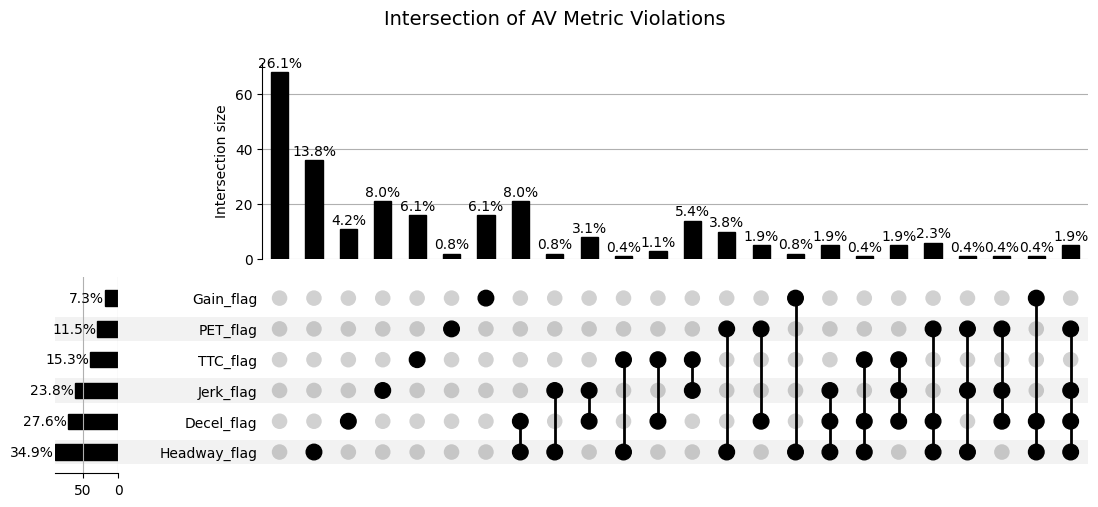

In [1]:
# Generating an UpSet plot for visualizing violation co-occerrences 

import pandas as pd
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# === Load merged dataset ===
merged = pd.read_csv("Merged_AV_Consensus_FB_I395.csv")

# === Metrics to include ===
metrics = ["TTC", "PET", "Decel", "Jerk", "Headway", "Gain"]

# === Build unified flag DataFrame (combine FB and I-395) ===
combined_flags = {}
for metric in metrics:
    val_x = merged.get(f"{metric}_x")
    val_y = merged.get(f"{metric}_y")
    flag_x = merged.get(f"{metric}_flag_x")
    flag_y = merged.get(f"{metric}_flag_y")

    # Only count rows with actual data (valid events)
    valid = val_x.notna() | val_y.notna()

    # Combined flag: True if flagged by either source, only where data is valid
    combined_flags[f"{metric}_flag"] = (
        ((flag_x & val_x.notna()).fillna(False) |
         (flag_y & val_y.notna()).fillna(False))
    ) & valid

# Convert to DataFrame
flags_combined_df = pd.DataFrame(combined_flags)
flag_cols = list(flags_combined_df.columns)

# === UpSet Plot for violations ===
upset_data = from_indicators(data=flags_combined_df, indicators=flag_cols)
plt.figure(figsize=(12, 6))
UpSet(upset_data, show_percentages=True).plot()
plt.suptitle("Intersection of AV Metric Violations", fontsize=14)
plt.savefig("Consensus_Upset_Plot.png", dpi=300)
plt.show()


## Sensitivity Analysis for Consensus Evaluation
Here, we are testing how changes in the thresholds we defined earlier can alter our findings. 

In [32]:
# Generating the sensitivity analysis dataset

import pandas as pd, itertools, numpy as np

# Importing
merged = pd.read_csv("Merged_AV_Consensus_FB_I395.csv")

# Defining threshold grids
TTC_vals = [2.0, 3.0, 4.0]
PET_vals = [1.25, 2.25, 3.25]
DECEL_vals = [1.0, 2.0, 3.0]
JERK_vals = [1.5, 2.5, 3.5]
HEADWAY_vals = [3.0, 4.0, 5.0]


def compute_flags(df, TTC, PET, DECEL, JERK, HEADWAY):
    f = pd.DataFrame({
        "TTC_flag": (df["TTC_x"].le(TTC) | df["TTC_y"].le(TTC)),
        "PET_flag": (df["PET_x"].le(PET) | df["PET_y"].le(PET)),
        "Decel_flag": (df["Decel_x"].gt(DECEL) | df["Decel_y"].gt(DECEL)),
        "Jerk_flag": (df["Jerk_x"].gt(JERK) | df["Jerk_y"].gt(JERK)),
        "Headway_flag": (df["Headway_x"].lt(HEADWAY) | df["Headway_y"].lt(HEADWAY)),
        "Gain_flag": (df["Gain_flag_x"] | df["Gain_flag_y"])
    })
    return f.fillna(False)

records = []
for ttc, pet, dec, jerk, hw in itertools.product(TTC_vals, PET_vals, DECEL_vals, JERK_vals, HEADWAY_vals):
    flags = compute_flags(merged, ttc, pet, dec, jerk, hw)
    base = {
        "TTC": ttc, "PET": pet, "Decel": dec, "Jerk": jerk, "Headway": hw,
        "any_violation_share": flags.any(axis=1).mean(),
        "multi_violation_share": (flags.sum(axis=1) > 1).mean(),
        "avg_flags_per_event": flags.sum(axis=1).mean(),
    }
    # Calculating individual rates
    for c in flags.columns:
        base[c.replace("_flag","_rate")] = flags[c].mean()
    # Pairwise overlaps
    for i, c1 in enumerate(flags.columns):
        for c2 in flags.columns[i+1:]:
            base[f"{c1}&{c2}"] = (flags[c1] & flags[c2]).mean()
    records.append(base)

df = pd.DataFrame(records)
df.to_csv("Sensitivity_Results.csv", index=False)

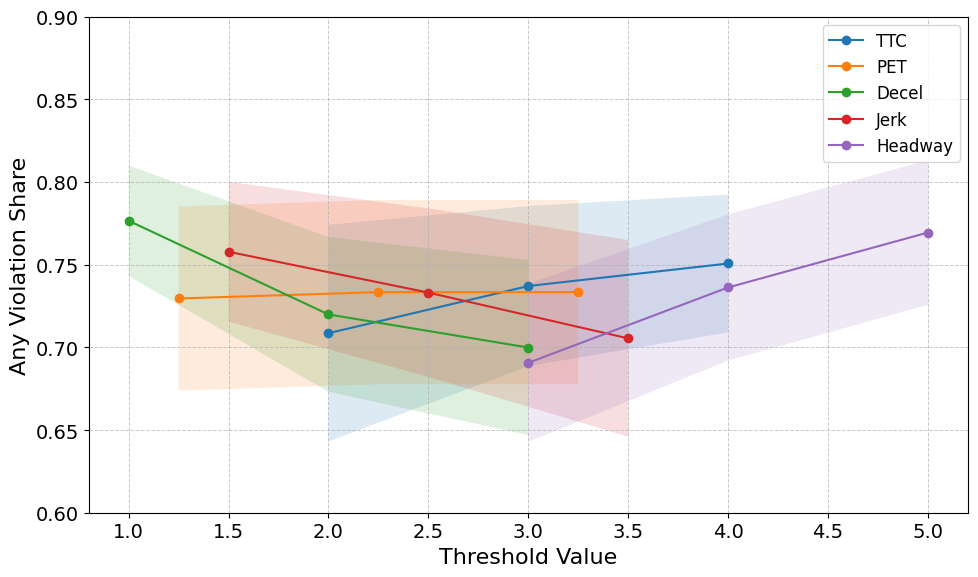

In [50]:
# Plotting means

import pandas as pd
import matplotlib.pyplot as plt

# Loading data
df = pd.read_csv("Sensitivity_Results.csv")

# Plot each metric with shaded variance region
plt.figure(figsize=(10, 6))

for metric in ["TTC", "PET", "Decel", "Jerk", "Headway"]:
    grouped = df.groupby(metric)["any_violation_share"]
    means = grouped.mean()
    stds = grouped.std()
    
    plt.plot(means.index, means.values, marker="o", label=metric)
    plt.fill_between(means.index,
                     means.values - stds.values,
                     means.values + stds.values,
                     alpha=0.15)

# One decimal place for x-axis tick labels
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Labels and formatting
plt.xlabel("Threshold Value", fontsize=16)
plt.ylabel("Any Violation Share", fontsize=16)
plt.ylim(0.6, 0.9)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Save as PNG (high resolution)
plt.tight_layout()
plt.savefig("Sensitivity_Violation_Share.png", dpi=300)
plt.show()


In [34]:
# Calculating variances for % of any violations across threshold levels

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sensitivity_df = pd.read_csv("Sensitivity_Results.csv")

#Computing global sensitivity ranking
agg = sensitivity_df.groupby(["TTC", "PET", "Decel", "Jerk", "Headway"])[["any_violation_share"]].mean().reset_index()
var_TTC = agg.groupby("TTC")["any_violation_share"].mean().var()
var_PET = agg.groupby("PET")["any_violation_share"].mean().var()
var_DECEL = agg.groupby("Decel")["any_violation_share"].mean().var()
var_JERK = agg.groupby("Jerk")["any_violation_share"].mean().var()
var_HEADWAY = agg.groupby("Headway")["any_violation_share"].mean().var()

ranking = pd.DataFrame({
    "Metric": ["TTC", "PET", "Decel", "Jerk", "Headway"],
    "Variance_in_AnyViolation": [var_TTC, var_PET, var_DECEL, var_JERK, var_HEADWAY]
}).sort_values("Variance_in_AnyViolation", ascending=False)

print("\n=== Sensitivity Ranking (higher variance = more sensitive) ===")
print(ranking)


=== Sensitivity Ranking (higher variance = more sensitive) ===
    Metric  Variance_in_AnyViolation
2    Decel                  0.001580
4  Headway                  0.001563
3     Jerk                  0.000686
0      TTC                  0.000463
1      PET                  0.000005


In [38]:
# Generating top 1, 2 and 3 violation combinations for headway adn deceleration (highest variances)

import pandas as pd
import itertools

# Loading sensitivity results
sensitivity_df = pd.read_csv("Sensitivity_Results.csv")

# Columns that contain pairwise overlaps
pair_cols = [c for c in sensitivity_df.columns if "&" in c]

def top_combos_by_metric(df, metric_name):
    # Finding all overlap columns that involve the metric
    related_cols = [c for c in pair_cols if metric_name in c]

    records = []
    # Iterating through each threshold level for that metric
    for level in sorted(df[metric_name].unique()):
        subset = df[df[metric_name] == level]

        # Computing mean occurrence rate across all combinations for that threshold
        means = subset[related_cols].mean().sort_values(ascending=False)
        top3 = means.head(3)

        for combo, val in top3.items():
            records.append({
                "Metric": metric_name,
                "Threshold": level,
                "Combination": combo.replace("_flag", ""),
                "Percent_occurrence": round(val * 100, 2)
            })

    return pd.DataFrame(records)

# Running for both headway and deceleration metrics
top_headway = top_combos_by_metric(sensitivity_df, "Headway")
top_decel = top_combos_by_metric(sensitivity_df, "Decel")

# Showing the results
print(f"top three headway combinations per threshold: \n {top_headway}")
print(f"top three deceleration combinations per threshold: \n {top_decel}")

top three headway combinations per threshold: 
     Metric  Threshold    Combination  Percent_occurrence
0  Headway        3.0  Decel&Headway               12.64
1  Headway        3.0    PET&Headway                6.00
2  Headway        3.0   Jerk&Headway                3.45
3  Headway        4.0  Decel&Headway               16.09
4  Headway        4.0    PET&Headway                7.92
5  Headway        4.0   Jerk&Headway                4.85
6  Headway        5.0  Decel&Headway               17.24
7  Headway        5.0    PET&Headway                7.92
8  Headway        5.0   Jerk&Headway                5.62
top three deceleration combinations per threshold: 
   Metric  Threshold    Combination  Percent_occurrence
0  Decel        1.0  Decel&Headway               19.28
1  Decel        1.0     Decel&Jerk               18.52
2  Decel        1.0      TTC&Decel               12.52
3  Decel        2.0  Decel&Headway               14.30
4  Decel        2.0     Decel&Jerk                9.96